In [ ]:
%%capture
# Run preprocess_models.ipynb to create preprocessed data (if not already done)
%run ../preprocess_models.ipynb

# Mixture Model

This notebook continues from `models.ipynb` and applies a mixture model approach to classify insurance claims.

**Prerequisites:** Run `models.ipynb` first to create the preprocessed data and train/test splits.

In [3]:
# Import required libraries
import pandas as pd
import numpy as np

# Load the preprocessed data from preprocess_models.ipynb
# All data is saved in data/processed/ after running preprocess_models.ipynb

df = pd.read_csv('../../data/processed/df_preprocessed.csv')
X_train = pd.read_csv('../../data/processed/X_train.csv')
X_test = pd.read_csv('../../data/processed/X_test.csv')
y_train = pd.read_csv('../../data/processed/y_train.csv').squeeze()
y_test = pd.read_csv('../../data/processed/y_test.csv').squeeze()

print("✓ Loaded preprocessed data from data/processed/")
print(f"\nData shape: {df.shape}")
print(f"Train set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\n✓ Ready for mixture model!")

✓ Loaded preprocessed data from data/processed/

Data shape: (9912, 18)
Train set: 7929 samples, 17 features
Test set: 1983 samples

✓ Ready for mixture model!


## Step 1: Prepare Data for Mixture Model

We need to encode all categorical variables and scale numerical features for the GMM to work properly.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np

# Prepare data for encoding
X_train_prep = X_train.copy()
X_test_prep = X_test.copy()

# Convert POSTAL_CODE to categorical for proper one-hot encoding
for df in [X_train_prep, X_test_prep]:
    if 'POSTAL_CODE' in df.columns:
        df['POSTAL_CODE'] = df['POSTAL_CODE'].astype('category')
    if 'GENDER' in df.columns:
        df['GENDER'] = df['GENDER'].map({'male': 0, 'female': 1}).astype('int')
    if 'RACE' in df.columns:
        df['RACE'] = df['RACE'].map({'majority': 0, 'minority': 1,}).astype('int')
    if 'VEHICLE_YEAR' in df.columns:
        df['VEHICLE_YEAR'] = df['VEHICLE_YEAR'].map({'before 2015': 0, 'after 2015': 1}).astype('int')
    if 'VEHICLE_TYPE' in df.columns:
        df['VEHICLE_TYPE'] = df['VEHICLE_TYPE'].map({'sedan': 0, 'sports car': 1}).astype('int')

# Encode categorical variables
X_train_encoded = pd.get_dummies(X_train_prep, drop_first=True)
X_test_encoded = pd.get_dummies(X_test_prep, drop_first=True)

# Ensure train and test have the same columns (in case of missing categories)
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Standardize features (important for GMM distance calculations)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)




print(f"Encoded feature space: {X_train_encoded.shape[1]} features")
print(f"Test set: {X_test_encoded.shape[0]} samples")
print(f"Training set: {X_train_scaled.shape[0]} samples")

Encoded feature space: 26 features
Test set: 1983 samples
Training set: 7929 samples


## Visualize Data in 2D Space

Before modeling, let's get an exploratory view of the full dataset structure using PCA to reduce dimensionality to 2D. This helps us understand if there are any natural clusters or separations in the data.

Full dataset: 9912 samples, 26 features
PCA explained variance ratio: [0.18278149 0.08325313]
Total variance explained by 2 components: 0.266


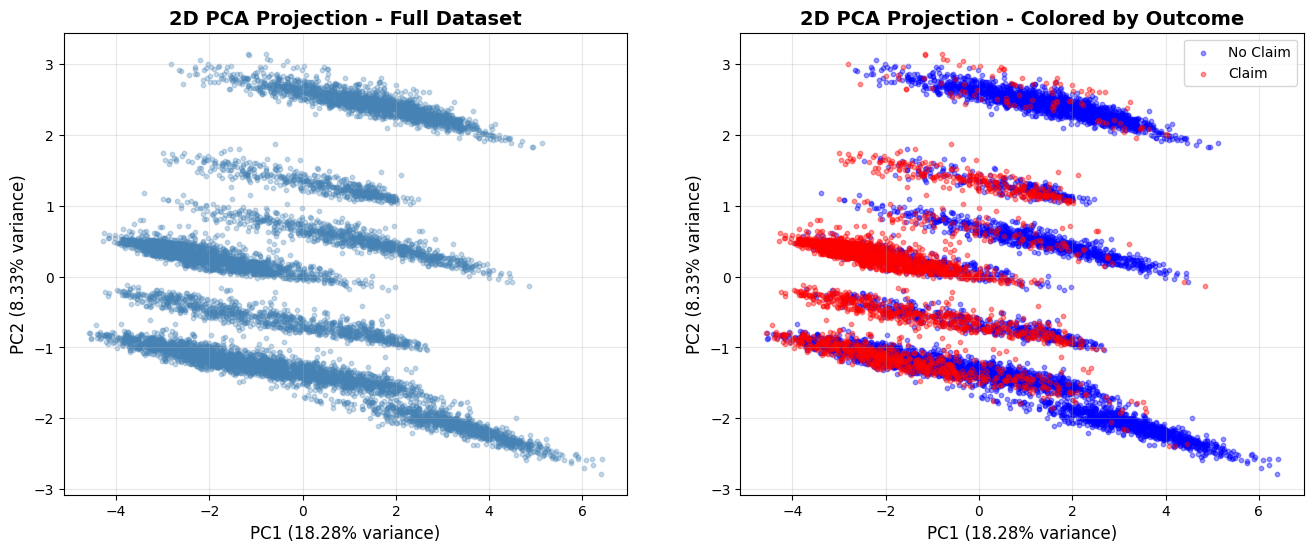

<Figure size 640x480 with 0 Axes>

In [53]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Combine train and test sets for a full dataset visualization
X_full = pd.concat([X_train_encoded, X_test_encoded], axis=0, ignore_index=True)
y_full = pd.concat([y_train, y_test], axis=0, ignore_index=True)

# Prepare data for encoding
X_full_prep = X_full.copy()

# Apply the same preprocessing pipeline: encoding + scaling
X_full_encoded = pd.get_dummies(X_full_prep, drop_first=True)
scaler_viz = StandardScaler()
X_full_scaled = scaler_viz.fit_transform(X_full_encoded)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2, random_state=42)
X_full_2d = pca.fit_transform(X_full_scaled)

print(f"Full dataset: {X_full_scaled.shape[0]} samples, {X_full_scaled.shape[1]} features")
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained by 2 components: {pca.explained_variance_ratio_.sum():.3f}")

# Create visualizations
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Plain scatter plot (overall structure)
axes[0].scatter(X_full_2d[:, 0], X_full_2d[:, 1], alpha=0.3, s=10, color='steelblue')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[0].set_title('2D PCA Projection - Full Dataset', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot 2: Colored by target (claim vs. no claim)
colors = ['blue', 'red']
labels = ['No Claim', 'Claim']
for outcome in [0, 1]:
    mask = (y_full == outcome)
    axes[1].scatter(
        X_full_2d[mask, 0], 
        X_full_2d[mask, 1], 
        alpha=0.4, 
        s=10, 
        color=colors[outcome],
        label=labels[outcome]
    )
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
axes[1].set_title('2D PCA Projection - Colored by Outcome', fontsize=14, fontweight='bold')

axes[1].legend(loc='best', fontsize=10)

axes[1].grid(alpha=0.3)

plt.show()
plt.tight_layout()

## cont. of preprocess the data

Correlation matrix computed for 26 features
Displaying correlations >= 0.45 or <= -0.45


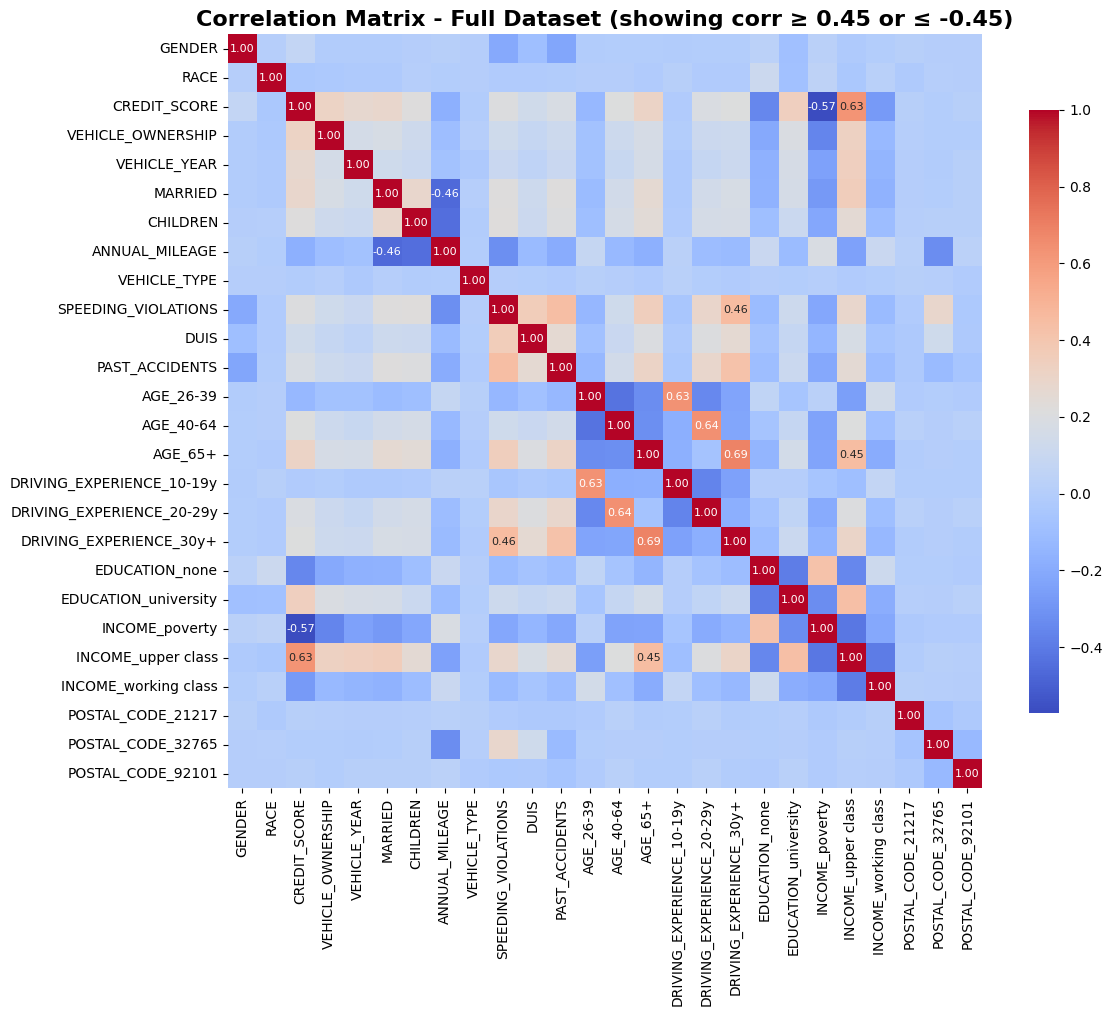

In [56]:
# Correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convert scaled array to DataFrame for correlation calculation
X_full_scaled_df = pd.DataFrame(X_full_scaled, columns=X_full_encoded.columns)

# Control thresholds for displaying correlation values
corr_threshold_high = 0.45  # Show correlations >= this value (strong positive)
corr_threshold_low = -0.45  # Show correlations <= this value (strong negative)

print(f"Correlation matrix computed for {X_full_scaled_df.shape[1]} features")
print(f"Displaying correlations >= {corr_threshold_high} or <= {corr_threshold_low}")

plt.figure(figsize=(12, 10))
correlation_matrix = X_full_scaled_df.corr()

# Create annotation mask: show values above high threshold OR below low threshold
mask_annotations = (correlation_matrix >= corr_threshold_high) | (correlation_matrix <= corr_threshold_low)

# Create a mask array for seaborn - True means hide the annotation
mask_for_annot = ~mask_annotations.values

# Create annotations - use empty string where mask is True
annot_data = correlation_matrix.values.copy()
annot_labels = np.empty_like(annot_data, dtype=object)
for i in range(annot_data.shape[0]):
    for j in range(annot_data.shape[1]):
        if mask_for_annot[i, j]:
            annot_labels[i, j] = ''
        else:
            annot_labels[i, j] = f'{annot_data[i, j]:.2f}'

sns.heatmap(correlation_matrix, annot=annot_labels, fmt='', cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, annot_kws={"size": 8})
plt.title(f'Correlation Matrix - Full Dataset (showing corr ≥ {corr_threshold_high} or ≤ {corr_threshold_low})', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()



## Step 2: Fit Gaussian Mixture Model

We'll start with K=3 components to discover latent risk groups in our population. The GMM will cluster customers based on their feature patterns.

In [ ]:
# Fit Gaussian Mixture Model with K=3 components
n_components = 3
gmm = GaussianMixture(
    n_components=n_components,
    covariance_type='full',  # Allow each component its own full covariance matrix
    random_state=42,
    n_init=10  # Multiple initializations for stability
)

gmm.fit(X_train_scaled)

# Get component assignments for training data
train_component_probs = gmm.predict_proba(X_train_scaled)  # Posterior probabilities
train_components = gmm.predict(X_train_scaled)  # Hard assignments

# print(train_component_probs[17:20])
# print(train_components[17:20])

print(f"Fitted GMM with {n_components} components")
print(f"\nComponent sizes in training set:")
for k in range(n_components):
    count = np.sum(train_components == k)
    pct = 100 * count / len(train_components)
    print(f"  Component {k}: {count} samples ({pct:.1f}%)")

print(f"\nDoes the GMM converge? {gmm.converged_}\nnumber of iterations: {gmm.n_iter_}")

## Step 3: Compute Component-Level Claim Probabilities

For each component, calculate the empirical claim rate (P(Y=1|component=k)) based on training data.

In [ ]:
# Calculate claim probability for each component
y_train_array = y_train.values 
component_claim_probs_hard = np.zeros(n_components)
component_claim_probs_soft = np.zeros(n_components)

print("Component Risk Profiles:")
print("-" * 60)
for k in range(n_components):
    # Hard assignments
    mask_hard = (train_components == k)
    n_samples_hard = mask_hard.sum()  

    if n_samples_hard > 0:
        claim_rate_hard = y_train_array[mask_hard].mean()
        n_claims_hard = y_train_array[mask_hard].sum()
    else:
        claim_rate_hard = np.nan
        n_claims_hard = 0
    
    component_claim_probs_hard[k] = claim_rate_hard

    # Soft assignments
    w_k = train_component_probs[:, k]  # Weights for component k
    total_weight = w_k.sum()
    
    if total_weight > 0:
        claim_rate_soft = np.sum(w_k * y_train_array) / total_weight
        effective_claims = np.sum(w_k * y_train_array)
    else:
        claim_rate_soft = np.nan
        effective_claims = 0.0
    
    component_claim_probs_soft[k] = claim_rate_soft
    
    print(f"Component {k}:")
    
    print(f"  HARD:")
    print(f"    Size: {n_samples_hard} samples ({100*n_samples_hard/len(y_train):.1f}%)")
    print(f"    Claims: {n_claims_hard} ({100*claim_rate_hard:.1f}%)")
    print(f"    Risk Level (hard): "f"{'HIGH' if claim_rate_hard > 0.3 else 'MEDIUM' if claim_rate_hard > 0.2 else 'LOW'}")

    print(f"  SOFT (responsibility-weighted):")
    print(f"    Effective size: {total_weight:.1f}")
    print(f"    Effective claims: {effective_claims:.1f}")
    print(f"    Claim rate (soft): {100*claim_rate_soft:.1f}%")
    print(f"    Risk Level (soft): "
          f"{'HIGH' if claim_rate_soft > 0.3 else 'MEDIUM' if claim_rate_soft > 0.2 else 'LOW'}\n")


print(f"Overall training claim rate: {y_train.mean():.4f}")

## Step 4: Make Predictions Using Mixture Model

For each customer, we compute:
- P(component=k|X) from the GMM (posterior probabilities)
- P(Y=1|component=k) from training data (component claim rates)
- Overall prediction: P(Y=1|X) = Σ P(component=k|X) × P(Y=1|component=k)

In [ ]:
def predict_mixture_model(X_scaled, gmm, component_claim_probs):
    """
    Predict claim probability using mixture model approach.
    
    Args:
        X_scaled: Standardized feature matrix
        gmm: Fitted GaussianMixture model
        component_claim_probs: Array of P(Y=1|component=k) for each component
    
    Returns:
        Array of predicted probabilities P(Y=1|X)
    """
    # Get posterior probabilities P(component=k|X)
    component_posteriors = gmm.predict_proba(X_scaled)
    
    # Compute weighted average: P(Y=1|X) = Σ P(component=k|X) * P(Y=1|component=k)
    y_pred_proba = component_posteriors @ component_claim_probs
    
    return y_pred_proba

# Generate predictions for training set (for sanity check)
y_train_pred_proba = predict_mixture_model(X_train_scaled, gmm, component_claim_probs_soft)
y_train_pred = (y_train_pred_proba >= 0.3).astype(int)

# Generate predictions for test set
y_test_pred_proba = predict_mixture_model(X_test_scaled, gmm, component_claim_probs_hard)
y_test_pred = (y_test_pred_proba >= 0.3).astype(int)

print("Predictions generated successfully!")
print(f"Train predicted claim rate: {y_train_pred.mean():.3f} (actual: {y_train.mean():.4f})")
print(f"Test predicted claim rate: {y_test_pred.mean():.3f} (actual: {y_test.mean():.4f})")

In [ ]:
def analyze_soft_assignments(component_probs, tol=1e-6, n_show=20):
    """
    Analyze non-hard (soft/mixed) component assignments.

    Args:
        component_probs: array of shape (n_samples, n_components),
                         typically from gmm.predict_proba(X)
        tol: tolerance for treating a max probability as "1"
        n_show: how many soft examples to print

    Returns:
        soft_df: DataFrame with soft assignments and sample indices
    """
    probs = np.asarray(component_probs)
    
    max_probs = probs.max(axis=1)
    is_hard = np.isclose(max_probs, 1.0, atol=tol)
    is_soft = ~is_hard

    soft_indices = np.where(is_soft)[0]
    soft_matrix = probs[is_soft]

    print(f"Total samples: {probs.shape[0]}")
    print(f"Hard-like assignments: {is_hard.sum()}")
    print(f"Non-hard (soft/mixed) assignments: {is_soft.sum()}")

    soft_df = pd.DataFrame(
        soft_matrix,
        columns=[f"component_{k}" for k in range(probs.shape[1])]
    )
    soft_df["sample_index"] = soft_indices

    print("\nExamples of non-hard assignments:")
    print(soft_df.head(n_show))

    return soft_df

soft_df = analyze_soft_assignments(train_component_probs, tol=1e-6, n_show=20)


## Step 5: Evaluate Model Performance

Let's assess how well our mixture model predicts insurance claims on the test set.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate metrics
print("=" * 70)
print("MIXTURE MODEL PERFORMANCE ON TEST SET")
print("=" * 70)

# Classification metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {roc_auc:.4f}")

# Confusion Matrix
print("\n" + "=" * 70)
print("CONFUSION MATRIX")
print("=" * 70)
cm = confusion_matrix(y_test, y_test_pred)
print(f"\n                 Predicted: No Claim  |  Predicted: Claim")
print(f"Actual: No Claim      {cm[0,0]:6d}         |      {cm[0,1]:6d}")
print(f"Actual: Claim         {cm[1,0]:6d}         |      {cm[1,1]:6d}")

# Classification Report
print("\n" + "=" * 70)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 70)
print(classification_report(y_test, y_test_pred, target_names=['No Claim', 'Claim']))

### Visualize ROC Curve

In [ ]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Mixture Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Analyze Component Assignments on Test Set

In [ ]:
# Analyze how test samples are distributed across components
test_components = gmm.predict(X_test_scaled)
test_component_probs = gmm.predict_proba(X_test_scaled)

print("=" * 70)
print("TEST SET COMPONENT ANALYSIS")
print("=" * 70)

y_test_array = y_test.values

for k in range(n_components):
    mask = (test_components == k)
    n_samples = mask.sum()
    actual_claim_rate = y_test_array[mask].mean()
    predicted_claim_rate = component_claim_probs_hard[k]
    
    print(f"\nComponent {k}:")
    print(f"  Test samples: {n_samples} ({100*n_samples/len(y_test):.1f}%)")
    print(f"  Predicted claim prob (from train): {predicted_claim_rate:.3f}")
    print(f"  Actual claim rate (in test): {actual_claim_rate:.3f}")
    print(f"  Difference: {abs(actual_claim_rate - predicted_claim_rate):.3f}")
    
    # Show prediction confidence
    avg_confidence = test_component_probs[mask, k].mean()
    print(f"  Average membership confidence: {avg_confidence:.3f}")

### Visualize Predicted vs Actual Probabilities

In [ ]:
# Distribution of predicted probabilities by actual outcome
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of predicted probabilities
axes[0].hist(y_test_pred_proba[y_test == 0], bins=30, alpha=0.6, label='No Claim (Actual)', color='blue', edgecolor='black')
axes[0].hist(y_test_pred_proba[y_test == 1], bins=30, alpha=0.6, label='Claim (Actual)', color='red', edgecolor='black')
axes[0].axvline(0.5, color='green', linestyle='--', linewidth=2, label='Decision Threshold')
axes[0].set_xlabel('Predicted Probability of Claim', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Predicted Probabilities', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot by actual outcome
test_df = pd.DataFrame({
    'Predicted_Prob': y_test_pred_proba,
    'Actual_Outcome': y_test
})
sns.boxplot(x='Actual_Outcome', y='Predicted_Prob', data=test_df, ax=axes[1])
axes[1].set_xlabel('Actual Outcome', fontsize=12)
axes[1].set_ylabel('Predicted Probability', fontsize=12)
axes[1].set_title('Predicted Probabilities by Actual Outcome', fontsize=13, fontweight='bold')
axes[1].set_xticklabels(['No Claim', 'Claim'])
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()